In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.metrics import accuracy_score , confusion_matrix


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('Tweets.csv')
df.head()               

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
df.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [6]:
df = df.dropna()

In [7]:
df.isnull().sum()

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

In [8]:
cat_id = {'neutral':1,'positive':2,'negative':0}
df['class'] = df['sentiment'].map(cat_id)
df.head()

,textID,text,selected_text,sentiment,class
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0
2,088c60f138,my boss is bullying me...,bullying me,negative,0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0


In [9]:
Batch_size = 512
Epochs = 80

In [10]:
X = df['text'].values
y = df['class'].values

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=42)

In [12]:
ohe = CountVectorizer()
X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

In [13]:
X_train

<23358x23907 sparse matrix of type '<class 'numpy.int64'>'
	with 267204 stored elements in Compressed Sparse Row format>

In [14]:
class SentimentData(Dataset):
    def __init__(self,X,y):
        super().__init__()
        self.X = torch.Tensor(X.toarray())
        self.y = torch.Tensor(y).type(torch.LongTensor)
        self.length = len(self.X)

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [15]:
train_ds = SentimentData(X=X_train,y=y_train)
test_ds = SentimentData(X_test,y_test)

In [16]:
train_loader = DataLoader(dataset=train_ds,batch_size=Batch_size,shuffle=True)
test_loader = DataLoader(dataset=test_ds,batch_size=15000)

In [17]:
class SentimentModel(nn.Module):
    def __init__(self,NUM_FEATURES,NUM_CLASSES,HIDDEN=10):
        super().__init__()
        self.linear = nn.Linear(NUM_FEATURES,HIDDEN)
        self.linear2= nn.Linear(HIDDEN,NUM_CLASSES)
        self.relu = nn.ReLU()
        self.log_softmax= nn.LogSoftmax(dim=1)
    
    def forward(self,x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x

In [18]:
model = SentimentModel(NUM_FEATURES=X_train.shape[1],NUM_CLASSES=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

In [19]:
train_losses = []
for e in range(Epochs):
    curr_loss = 0
    for xb,yb in train_loader:
        optimizer.zero_grad()
        y_pred_log = model(xb)
        loss =  criterion(y_pred_log,yb.long())

        curr_loss+= loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(curr_loss)
    print(f"Line {e} , Loss : {curr_loss}")

Line 0 , Loss : 50.6296124458313
Line 1 , Loss : 46.4247105717659
Line 2 , Loss : 41.80967938899994
Line 3 , Loss : 37.27424091100693
Line 4 , Loss : 33.30828821659088
Line 5 , Loss : 29.928759157657623
Line 6 , Loss : 27.14585369825363
Line 7 , Loss : 24.77044215798378
Line 8 , Loss : 22.772142380475998
Line 9 , Loss : 21.037288278341293
Line 10 , Loss : 19.574050575494766
Line 11 , Loss : 18.270321518182755
Line 12 , Loss : 17.064119160175323
Line 13 , Loss : 16.041335999965668
Line 14 , Loss : 15.12220412492752
Line 15 , Loss : 14.290034383535385
Line 16 , Loss : 13.548844546079636
Line 17 , Loss : 12.869413286447525
Line 18 , Loss : 12.28149826824665
Line 19 , Loss : 11.693582743406296
Line 20 , Loss : 11.176350876688957
Line 21 , Loss : 10.720909416675568
Line 22 , Loss : 10.296330630779266
Line 23 , Loss : 9.867652103304863
Line 24 , Loss : 9.51821482181549
Line 25 , Loss : 9.170478016138077
Line 26 , Loss : 8.825797840952873
Line 27 , Loss : 8.525770500302315
Line 28 , Loss : 8.

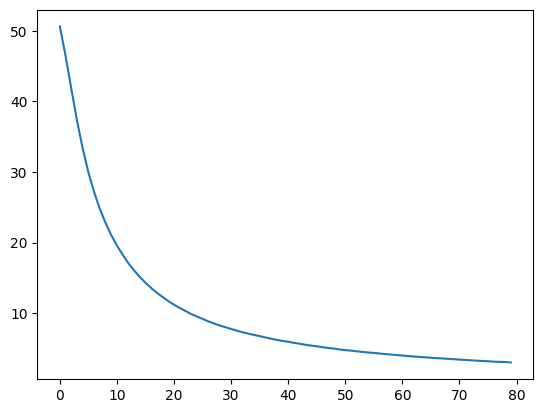

In [24]:
sns.lineplot(x=list(range(len(train_losses))),y=train_losses)
plt.show()

In [25]:
with torch.no_grad():
    for xb,yb in test_loader:
        y_test_pred = model(xb)
        y_test_pred = torch.argmax(y_test_pred,dim=1)

y_test_pred_np = y_test_pred.squeeze().cpu().numpy()

In [26]:
acc = accuracy_score(y_pred=y_test_pred_np,y_true=y_test)
acc

0.631004366812227

In [28]:
most_common_cnt = Counter(y_test).most_common()[0][1]
print("naive classifier" , (most_common_cnt/len(y_test) * 100 ))

naive classifier 40.85395439107229


<Axes: >

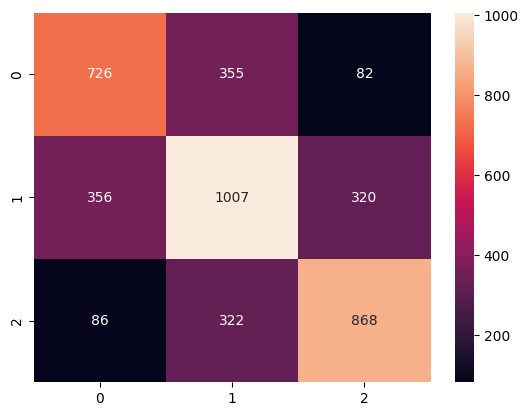

In [29]:
sns.heatmap(confusion_matrix(y_test_pred_np,y_test), annot=True,fmt=".0f")